Statistical Analysis

In [59]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopandas as gpd 
import contextily as ctx
from shapely.geometry import Point
import math
import numpy as np


load and clean data

In [60]:
main_data = pd.read_csv('../data/processed_data/seattle_wa_processed.csv')

In [61]:
main_data = main_data.drop('PropertyId', axis=1)
# Ensure all data is numeric before calculating the correlation matrix
main_data = main_data.apply(pd.to_numeric, errors='ignore')
lower_cap = main_data['MaxRent'].quantile(0.00)
upper_cap = main_data['MaxRent'].quantile(0.995)
main_data['MaxRent'] = main_data['MaxRent'].clip(lower_cap, upper_cap)

/tmp/ipykernel_1249/104269111.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  main_data = main_data.apply(pd.to_numeric, errors='ignore')


General Statistics 

In [62]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): print(main_data.describe())


          Latitude    Longitude  ReviewScore  Neighborhood_Label      Leisure  \
count  5852.000000  5852.000000  5852.000000         5852.000000  5852.000000   
mean     47.631053  -122.331415     2.538175           31.966678     5.213090   
std       0.035949     0.021606     2.324256           22.450395     3.749945   
min      47.488018  -122.410321     0.000000            0.000000     0.000000   
25%      47.612891  -122.342799     0.000000           14.000000     2.000000   
50%      47.620563  -122.331101     3.900000           20.000000     4.000000   
75%      47.657972  -122.318281     4.800000           57.000000     8.000000   
max      47.732619  -122.252597     5.000000           74.000000    21.000000   

        Technology     Services     Location  Fitness & Wellness  \
count  5852.000000  5852.000000  5852.000000         5852.000000   
mean      5.137218     1.285373     7.329460            0.366029   
std       2.882144     0.981579     4.163649            0.667886  

distribution of rent prices 

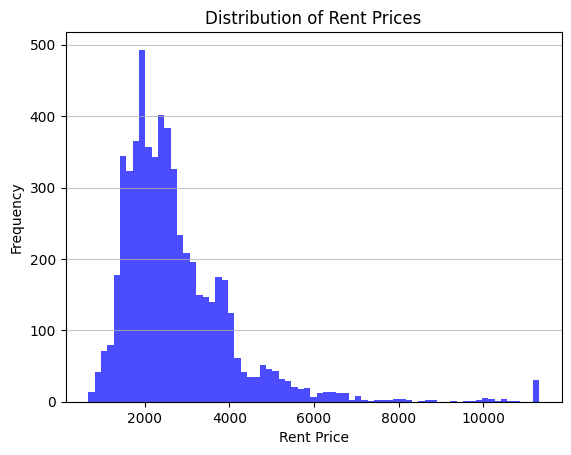

In [63]:

plt.hist(main_data['MaxRent'], bins='auto', color='blue', alpha=0.7)
plt.title('Distribution of Rent Prices')
plt.xlabel('Rent Price')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

Linear Relationship between sqfoot and rent

Text(0.5, 1.0, 'Rent vs. Square Footage')

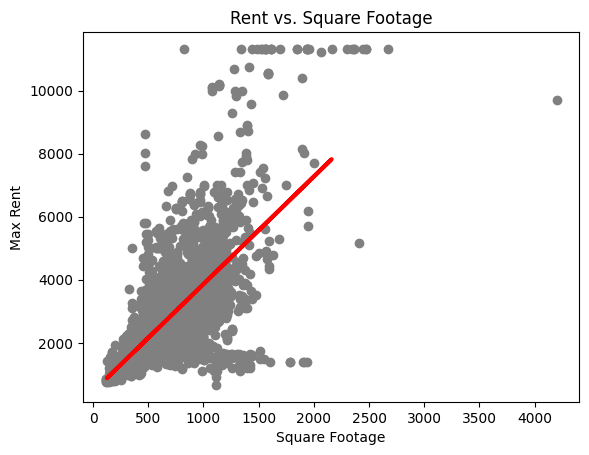

In [64]:
X = main_data[['SquareFootage']]
y = main_data['MaxRent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plt.scatter(main_data['SquareFootage'], main_data['MaxRent'], color='grey')
plt.plot(X_test, y_pred, color='red', linewidth=3, label='Predicted Rent')
plt.xlabel('Square Footage')
plt.ylabel('Max Rent')
plt.title('Rent vs. Square Footage')

Correlation Matrix

Text(0.5, 1.0, 'Correlation Matrix')

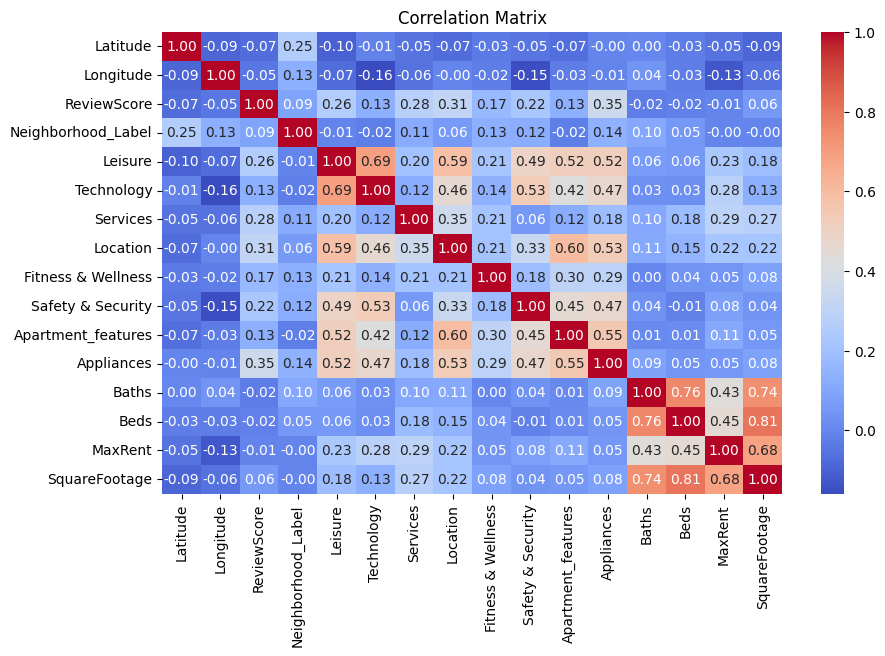

In [65]:
plt.figure(figsize=(10,6))
corr_matrix = main_data.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')


Visualizing Neighborhoods based on rent and amount

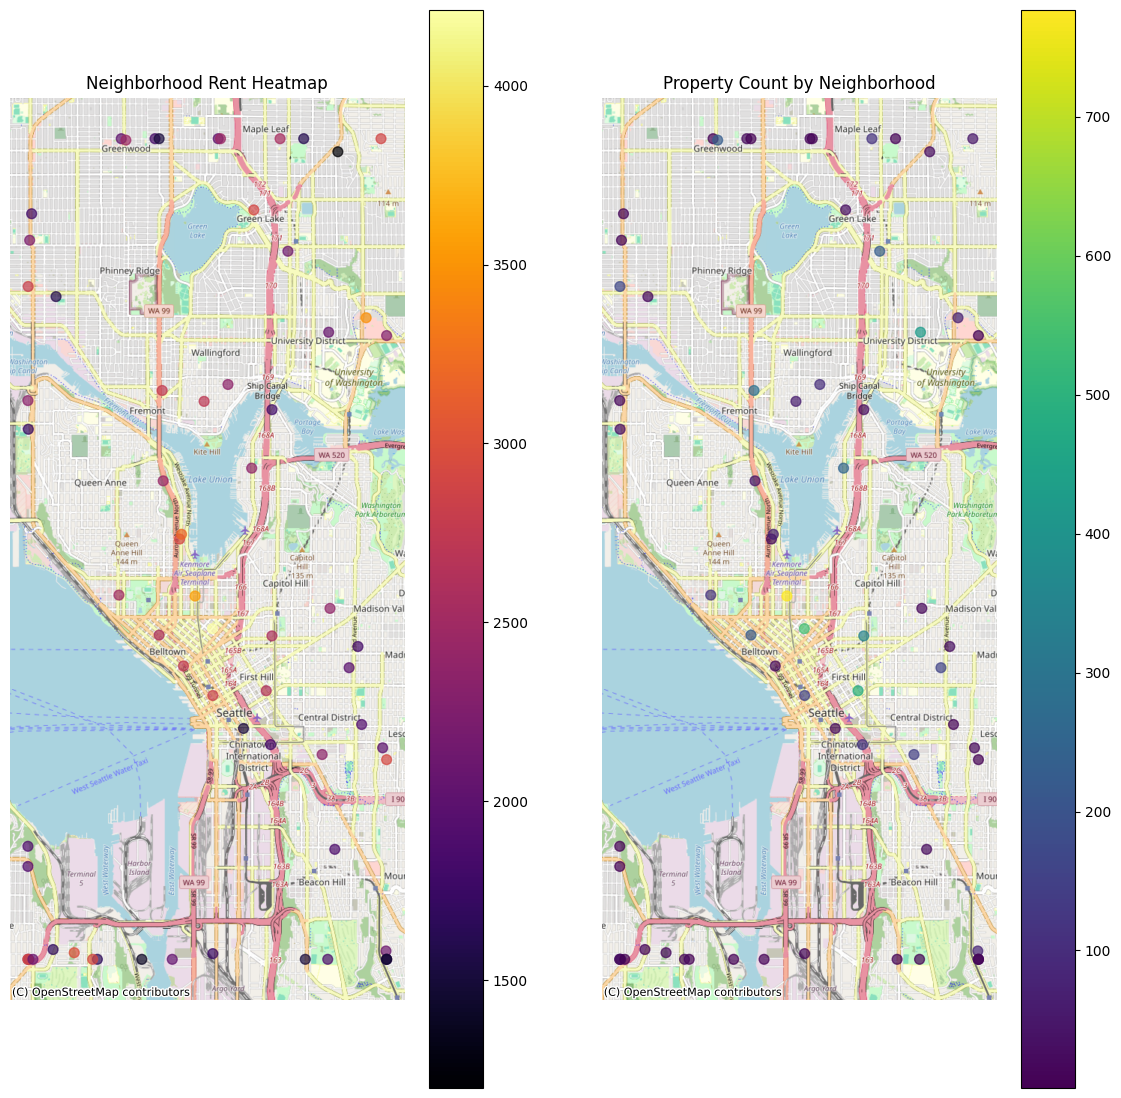

In [66]:
# Handle miscaculated lat long from addresses
lower_cap = main_data['Latitude'].quantile(0.05)
upper_cap = main_data['Latitude'].quantile(0.95)
main_data['Latitude'] = main_data['Latitude'].clip(lower_cap, upper_cap)

lower_cap = main_data['Longitude'].quantile(0.05)
upper_cap = main_data['Longitude'].quantile(0.95)
main_data['Longitude'] = main_data['Longitude'].clip(lower_cap, upper_cap)

# Get meta-data for neighborhoods
neighborhoods = main_data.groupby('Neighborhood_Label').agg(
    MaxRent_Mean=('MaxRent', 'mean'),
    MaxRent_Std=('MaxRent', 'std'),
    Latitude_Mean=('Latitude', 'mean'),
    Longitude_Mean=('Longitude', 'mean'),
    Property_Count=('Neighborhood_Label', 'size')
)

# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(neighborhoods['Longitude_Mean'], neighborhoods['Latitude_Mean'])]
gdf = gpd.GeoDataFrame(neighborhoods, geometry=geometry)
gdf.crs = 'EPSG:4326'
gdf = gdf.to_crs(epsg=3857)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 14))

# Plot 1: Heatmap based on MaxRent_Mean
gdf.plot(ax=ax1, marker='o', column='MaxRent_Mean', cmap='inferno', legend=True, markersize=50, alpha=0.7)
ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik)
ax1.set_axis_off()
ax1.set_title('Neighborhood Rent Heatmap')

# Plot 2: Heatmap based on Property_Count
gdf.plot(ax=ax2, marker='o', column='Property_Count', cmap='viridis', legend=True, markersize=50, alpha=0.7)
ctx.add_basemap(ax2, source=ctx.providers.OpenStreetMap.Mapnik)
ax2.set_axis_off()
ax2.set_title('Property Count by Neighborhood')


plt.show()